In [1]:
import pickle
from datetime import datetime
from dateutil.tz import tzoffset

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from torch import optim
from scipy.stats import kendalltau, spearmanr
from sklearn.preprocessing import OneHotEncoder

In [2]:
with open("players.pkl", "rb") as fio:
    players = pickle.load(fio)

In [3]:
with open("results.pkl", "rb") as fio:
    results = pickle.load(fio)

In [4]:
with open("tournaments.pkl", "rb") as fio:
    tournaments = pickle.load(fio)

In [5]:
dateformat = "%Y-%m-%dT%H:%M:%S%z"

In [6]:
train_data =  []
test_data = []

for key, value in results.items():
    for team in value:
        for team_member in team["teamMembers"]:
            tournament_year = datetime.strptime(tournaments[key]["dateStart"], dateformat).year
            if team.get("mask", None) and tournament_year == 2019:
                train_data.append({
                    "tournament_id": key,
                    "tournament_name": tournaments.get(key).get("name"),
                    "team_id": team["team"]["id"],
                    "team_name": team["team"]["name"],
                    "questions_mask": team.get("mask", None),
                    "questionQty": tournaments.get(key).get("questionQty"),
                    "position": team.get("position", None),
                    "player_id": team_member["player"]["id"],
                    "player_name": team_member["player"]["surname"] + " " + \
                                   team_member["player"]["name"] + " " + \
                                   team_member["player"]["patronymic"]
                })
            elif team.get("mask", None) and tournament_year == 2020:
                test_data.append({
                    "tournament_id": key,
                    "tournament_name": tournaments.get(key).get("name"),
                    "team_id": team["team"]["id"],
                    "team_name": team["team"]["name"],
                    "position": team.get("position", None),
                    "player_id": team_member["player"]["id"],
                    "player_name": team_member["player"]["surname"] + " " + \
                                   team_member["player"]["name"] + " " + \
                                   team_member["player"]["patronymic"]
                })

In [7]:
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [8]:
del results

In [9]:
train_data["questionQty"] = train_data["questionQty"].apply(lambda x: sum(list(x.values())))

In [10]:
train_data[train_data["questions_mask"].apply(len) != train_data["questionQty"]]["tournament_id"].nunique()

12

In [11]:
train_data = train_data[train_data["questions_mask"].apply(len) == train_data["questionQty"]].copy()

/home/imd/miniconda3/envs/made_advance/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


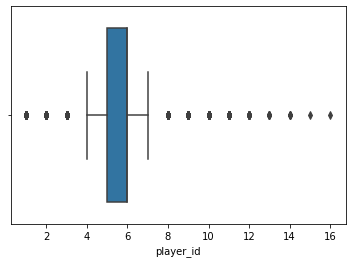

In [12]:
sns.boxplot(train_data.groupby(["team_id", "tournament_id"])["player_id"].nunique());

In [13]:
train_data.shape

(414743, 9)

In [14]:
train_data = pd.merge(
    train_data,
    train_data.groupby("team_id")["player_id"].value_counts().rename("played_in_team").reset_index(),
    on = ["team_id", "player_id"],
    how="inner"
)

In [15]:
most_played_index = train_data.groupby(["tournament_id", "team_id"]).apply(lambda x: x.sort_values("played_in_team", ascending=False).iloc[:6].index.values)

In [16]:
good_index = []
for index in most_played_index:
    good_index.extend(index)

/home/imd/miniconda3/envs/made_advance/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


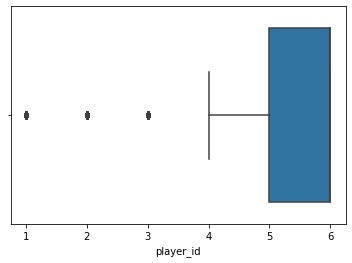

In [17]:
sns.boxplot(train_data.loc[good_index].groupby(["team_id", "tournament_id"])["player_id"].nunique());

In [18]:
train_data.shape[0], test_data.shape[0]

(414743, 112841)

In [19]:
train_data["tournament_id"].nunique(), test_data["tournament_id"].nunique()

(675, 173)

In [20]:
question_answer_data = {
    "question": [],
    "player": [],
    "initial_label": [],
    "team_id": [],
    "tournament_id": []
}
for tour_id, team_id, player_id, mask in zip(train_data["tournament_id"], train_data["team_id"], train_data["player_id"], train_data["questions_mask"]):
    for i, result in enumerate(mask):
        if result != "X" and result != "?":
            question_answer_data["tournament_id"].append(tour_id)
            question_answer_data["team_id"].append(team_id)
            question_answer_data["question"].append(f"{tour_id}_{i}")
            question_answer_data["player"].append(player_id)
            question_answer_data["initial_label"].append(int(result))

In [21]:
question_answer_data = pd.DataFrame(question_answer_data)

In [22]:
question_answer_data["player"] = question_answer_data["player"].astype(np.int32)
question_answer_data["team_id"] = question_answer_data["team_id"].astype(np.int32)
question_answer_data["tournament_id"] = question_answer_data["tournament_id"].astype(np.int32)
question_answer_data["question"] = question_answer_data["question"]
question_answer_data["initial_label"] = question_answer_data["initial_label"].astype(np.uint8)

In [23]:
encoder = OneHotEncoder()

train_data = encoder.fit_transform(question_answer_data[["player", "question"]])

In [24]:
class LogisticRegression(nn.Module):
    
    def __init__(self, n_features):
        
        super().__init__()
        self.fc = nn.Linear(n_features, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        return self.sigmoid(self.fc(x))

In [25]:
def m_step(model, x, y, lr=1e-4, n_iter=50):
    
    model.fc.reset_parameters()
    criteria = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr)
    for i in range(n_iter):

        optimizer.zero_grad()
        output = model(x)
        loss = criteria(output, y)
        loss.backward()
        optimizer.step()

In [26]:
train_data = train_data.tocoo()

In [27]:
x = torch.sparse.FloatTensor(
    torch.LongTensor(np.vstack((train_data.row, train_data.col))),
    torch.FloatTensor(train_data.data)
)

In [28]:
y = torch.FloatTensor(question_answer_data["initial_label"].values).view(-1, 1)

In [29]:
model = LogisticRegression(x.shape[1])

In [30]:
%%time
m_step(model, x, y, lr=1, n_iter=100)

CPU times: user 4min 40s, sys: 42.6 s, total: 5min 23s
Wall time: 3min 12s


In [31]:
def calc_metrics(data, encoder, parameters, intercept):
    player_weights = {}
    count = 0
    question_sum = 0
    player_sum = 0
    player_cnt = 0
    for i, c in enumerate(encoder.get_feature_names()):
        if c.startswith("x0_"):
            player_weights[int(c[3:])] = parameters[i]
            player_sum += parameters[i]
            player_cnt += 1
        else:
            question_sum += parameters[i]
            count += 1
    question_mean = question_sum / count
    data["player_weights"] = data["player_id"].map(player_weights)
    data["player_weights"].fillna(player_sum / player_cnt, inplace=True)
    data["players_proba"] = data["player_weights"].apply(lambda x: 1 / (1 + np.exp(-(x + question_mean + intercept))))
    probas = data.groupby(["tournament_id", "team_id"])["players_proba"].apply(lambda x: np.prod(1 - x))
    position = data.groupby(["tournament_id", "team_id"])["position"].first()
    group_data = pd.concat([probas, position], axis=1)
    group_data.sort_values(["tournament_id", "players_proba"], ascending=[True, True], inplace=True)
    spear = group_data.groupby("tournament_id").apply(lambda x: spearmanr(x["position"], x["players_proba"]).correlation).mean()
    kendl = group_data.groupby("tournament_id").apply(lambda x: kendalltau(x["position"], x["players_proba"]).correlation).mean()
    print(f"spearman: {spear}")
    print(f"kendl: {kendl}")

In [32]:
calc_metrics(test_data, encoder, model.fc.weight.data[0].numpy(), model.fc.bias.data[0].numpy())

spearman: 0.7859987474554763
kendl: 0.6290909944016051


In [33]:
def e_step(data, predicts):
    data["label"] = predicts
    data.loc[data["initial_label"] == 0, "label"] = 0
    idx = data["initial_label"] == 1
    sp = data.loc[idx].groupby(["team_id", "question"])["label"].transform(lambda x: 1 - np.prod(1 - x.values))
    data.loc[idx, "label"] = data.loc[idx, "label"] / sp  
    return data

In [ ]:
predicts = model(x).detach().numpy().ravel()
for i in range(0, 20):
    question_answer_data = e_step(question_answer_data, predicts)
    y = torch.FloatTensor(question_answer_data["label"].values).view(-1, 1)
    m_step(model, x, y, lr=1, n_iter=100)
    predicts = model(x).detach().numpy().ravel()
    print(f"Iter: {i}")
    calc_metrics(test_data, encoder, model.fc.weight.data[0].numpy(), model.fc.bias.data[0].numpy())

Iter: 0
spearman: 0.7939598001571143
kendl: 0.6383555941080596
Iter: 1
spearman: 0.7939381135646116
kendl: 0.638045444316909
Iter: 2
spearman: 0.7967572727805525
kendl: 0.6403590400405925


In [ ]:
question_weights = {}
for i, c in enumerate(encoder.get_feature_names()):
    if c.startswith("x1_"):
        question_weights[c[3:]] = parameters[i]

In [ ]:
tournament_weights = question_answer_data.groupby("tournament_id")["question"].apply(lambda x: np.mean([question_weights[q] for q in x])).sort_values()

In [ ]:
tournament_weights.reset_index()["tournament_id"].apply(lambda x: tournaments[x]["name"]).head(20)

In [ ]:
tournament_weights.reset_index()["tournament_id"].apply(lambda x: tournaments[x]["name"]).tail(20)

In [57]:
def get_top_players(parameters, n=20):
    player_weights = {}
    for i, c in enumerate(encoder.get_feature_names()):
        if c.startswith("x0_"):
            player_weights[int(c[3:])] = parameters[i]
    top_players = sorted([(k, v) for k, v in player_weights.items()], reverse=True, key=lambda x: x[1])[:n]
    print(top_players)
    top_players = [
        players[i]["surname"] + " " + 
        players[i]["name"] + " " + 
        players[i]["patronymic"] + " " + str(i) 
        for i, _ in top_players
    ]
    return top_players

In [ ]:
player_weights = {}
for i, c in enumerate(encoder.get_feature_names()):
    if c.startswith("x0_"):
        player_weights[int(c[3:])] = parameters[i + 1]

In [ ]:
top_20_players = sorted([(k, v) for k, v in player_weights.items()], reverse=True, key=lambda x: x[1])[:20]

In [ ]:
top_20_players = {v for v, _ in top_20_players}

In [ ]:
[players[i]["surname"] + " " + players[i]["name"] + " " + players[i]["patronymic"] + " " + str(i) for i in top_20_players]

In [ ]:
question_answer_data[question_answer_data["player"].isin(top_20_players)].groupby("player")["tournament_id"].nunique()